In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
from scipy.stats import jarque_bera
from scipy.stats import normaltest
import statsmodels.api as sm
import seaborn as sns; sns.set()

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()



In [49]:
weather_df.head(5)

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.


In [50]:
# humidity, windspeed, windbearing, and pressure ==> Independent variables 

In [51]:
# checking for missing values

total_missing = weather_df.isnull().sum().sort_values(ascending=False)
percent_missing = (weather_df.isnull().sum()/weather_df.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total','Percent'])
missing_data

,Total,Percent
dailysummary,0,0.000
pressure,0,0.000
loudcover,0,0.000
visibility,0,0.000
windbearing,0,0.000
windspeed,0,0.000
humidity,0,0.000
apparenttemperature,0,0.000
temperature,0,0.000
preciptype,0,0.000


In [52]:
indpt_variable = weather_df[['humidity','windspeed','windbearing','pressure']]

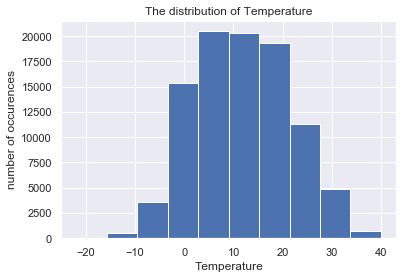

In [53]:
# Looking at the target variable Temperature

plt.hist(weather_df.temperature)
plt.title('The distribution of Temperature')
plt.xlabel('Temperature')
plt.ylabel('number of occurences')
plt.show()

The target variable temperature seems to be distributed normally.

Below we will get correlations for the features and the target varible. I will use the absolute value.

In [54]:
weather_df.corr(method='pearson')

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
temperature,1.000,0.993,-0.632,0.009,0.030,0.393,nan,-0.005
apparenttemperature,0.993,1.000,-0.603,-0.057,0.029,0.382,nan,-0.000
humidity,-0.632,-0.603,1.000,-0.225,0.001,-0.369,nan,0.005
windspeed,0.009,-0.057,-0.225,1.000,0.104,0.101,nan,-0.049
windbearing,0.030,0.029,0.001,0.104,1.000,0.048,nan,-0.012
visibility,0.393,0.382,-0.369,0.101,0.048,1.000,nan,0.060
loudcover,nan,nan,nan,nan,nan,nan,nan,nan
pressure,-0.005,-0.000,0.005,-0.049,-0.012,0.060,nan,1.000


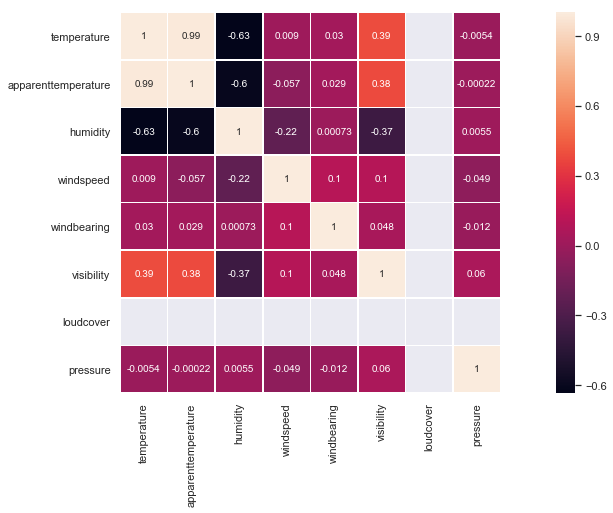

In [55]:


plt.figure(figsize=(20,7))

sns.heatmap(weather_df.corr(), square=True, annot=True, linewidths=.5)

plt.show()

# Regression Model:

In [56]:
X = weather_df[['humidity','windspeed','windbearing','pressure']]

Y = weather_df.temperature

In [57]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.750e+04
Date:                Mon, 10 Feb 2020   Prob (F-statistic):               0.00
Time:                        12:11:03   Log-Likelihood:            -3.2821e+05
No. Observations:               96453   AIC:                         6.564e+05
Df Residuals:                   96448   BIC:                         6.565e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9264      0.233    162.709      0.000      37.470      38.383
humidity      -32.4962      0.123   -264.288      0.000     -32.737     -32.255
windspeed      -0.2014      0.003    -57.557      0.000      -0.208      -0.195
windbearing     0.0040      0.000     18.463      0.000       0.004       0.004
pressure       -0.0007      0.000     -3.452      0.001      -0.001      -0.000
==============================================================================
Omnibus:                     3375.432   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3793.297
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       3.339   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Gauss Markov Assumptions or Gauss Markov Conditions


Coefficients: 
 [2. 3. 4. 5.]

Intercept: 
 1.0000000000154614


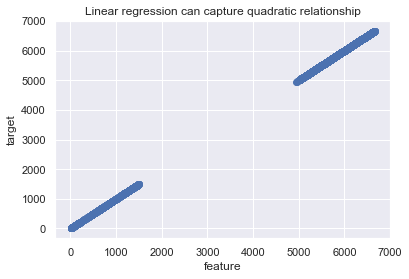

In [70]:
#'humidity','windspeed','windbearing','pressure'

weather_df['Y'] = 1 + 2*weather_df.humidity + 3*weather_df.windspeed + 4*weather_df.windbearing + 5*weather_df.pressure

lrm_example = linear_model.LinearRegression()
lrm_example.fit(weather_df[['humidity','windspeed','windbearing','pressure']],weather_df['Y'])

predictions = lrm_example.predict(weather_df[['humidity','windspeed','windbearing','pressure']])

print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

plt.scatter(weather_df['Y'], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()


In [74]:
lrm = linear_model.LinearRegression()
lrm.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [75]:
predictions = lrm.predict(X)
errors = Y - predictions

print('mean of errors in weather model is: {}'.format(np.mean(errors)))

mean of errors in weather model is: -2.7968508502449862e-15


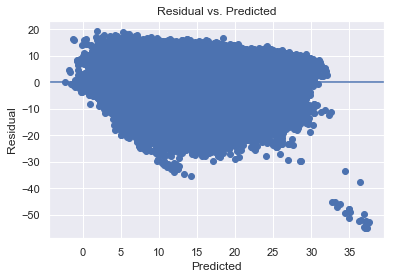

In [76]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

null hypothesis for both tests is that the errors are homoscedastic. 

In [77]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic

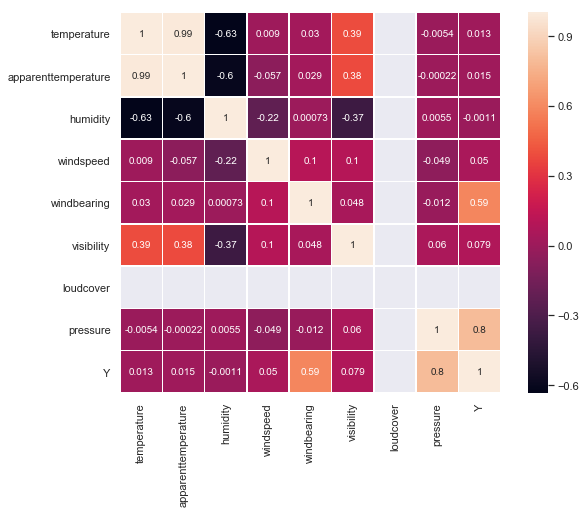

In [78]:
plt.figure(figsize=(10,7))

sns.heatmap(weather_df.corr(), square=True, annot=True, linewidths=.5)

plt.show()

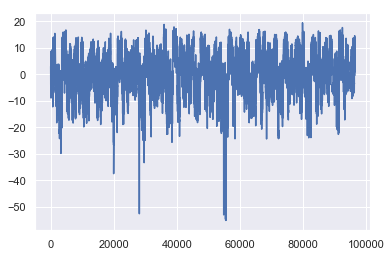

In [79]:
plt.plot(errors)
plt.show()

error terms of our model are uncorrelated with each other.

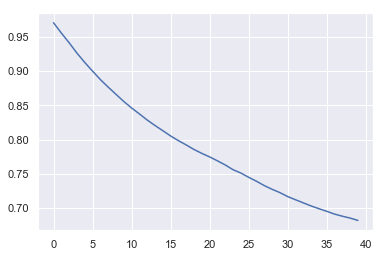

In [80]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

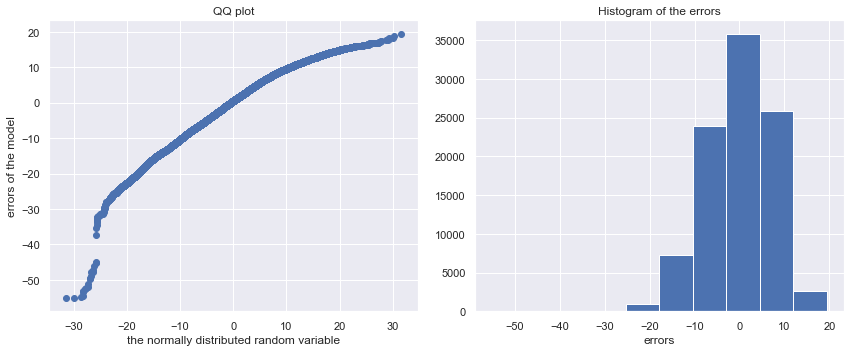

In [81]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) 
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [82]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [83]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.2967352523065 and p value is 0.0
Normality test statistics is 3375.4323076995424 and p value is 0.0


p-values of both tests indicate that our errors are not normally distributed.